In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
%matplotlib inline

In [2]:
import torch
import torch.optim as optim

In [3]:
from opt import *
from dojo import *
from display import*

In [118]:
#2-layer 784-800-10
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN,self).__init__()
        
        self.s = 28**2
        self.p = 800
        self.nl = 10
        
        self.activation = torch.nn.functional.relu
        self.prob = torch.nn.functional.softmax
        
        self.pre = lambda x : x.reshape((x.shape[0], np.prod(x.shape[1:]))).to(torch.float32)
        self.layers = torch.nn.ModuleList([torch.nn.Linear(self.s, self.p, bias=False), torch.nn.Linear(self.p, self.nl, bias=False)])
        self.post = [self.activation,self.prob]

        for i in range(len(self.layers)):
            torch.nn.init.xavier_uniform_(self.layers[i].weight)       
        
    ###############    
    def init_train(self, base_lr, lr_decay):
        optimizer = optim.ASGD(net.parameters(), lr=base_lr) # optim.Adam(net.parameters(), lr=base_lr)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_decay,])
        criterion = torch.nn.MSELoss()
        return optimizer, scheduler, criterion
    
    def train(self, x, y, optimizer, criterion):
        outputs = self.forward(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    ###############   
    
    def forward(self, x):
        x = self.pre(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.post[i](x)
        return x

    def predict(self,x):
        x = self.forward(x)
        return torch.argmax(x,axis=-1)
       
#2-layer 784-800-10, FFA - does not work; max was 17% accurate
#5-layer 784-300-300-300-300-300, FFA - worse, even with bias...9.8%, same as random
# now adding in previous layer goodness (as an average).. to get even worse perf of 3.7%?
# repeating without bias again.. 1.5% accuracy - 
# returning to 2-layer... 14.7%
# trying replacement of second relu with sigmoid - not useful
# combining + and - batch together

class FFA():
    def __init__(self,device):
        super(FFA,self).__init__()
        
        self.s = 28**2
        self.p = 800 #300 #
        self.nl = 10
        self.rep = 1 #4#
        
        self.device = device
        self.activation = torch.nn.functional.relu
        self.id = torch.nn.Identity()
        self.norm = torch.nn.functional.normalize
        self.prob = torch.nn.functional.softmax
        
        self.pre = lambda x : self.norm(x.reshape((x.shape[0], np.prod(x.shape[1:]))).to(torch.float32))
        self.layers = [FFALinear(self.s, self.p, device=self.device, bias=False),
                                           *([FFALinear(self.p, self.nl, device=self.device, bias=False)]*self.rep)]
        self.sizes = [self.s,*([self.p]*self.rep),self.nl]
        self.post = [self.activation,*([self.id]*self.rep)] # replaced last softmax with identity

        for i in range(len(self.layers)):
            # self.layers[i].requires_grad = False
            self.layers[i].reset_parameters()     
    
    #FFA
    def goodness(self,activity,th=0.0):
        return torch.sum(torch.pow(activity,2), axis=-1) - th # net_activity
    
    def px(self,net_activity):
        return torch.nn.functional.sigmoid(net_activity)
    
    def update_FFA(self, i, lr, criterion, x, data_type): # sup  # data_type: 1 if positive, 0 if negative
        nbatch = x.size(dim=0)
        layer = self.layers[i]
        
        y = layer.forward(x)
        
        signfactor = 2 * data_type - 1
        th = (-0.5) * data_type + (1.5) * (1-data_type) # https://www.desmos.com/calculator/wkp8d7tlif
        good = self.goodness(y,th) * signfactor
    
        D = self.px(1 - good) * signfactor * 2 * lr
        
        
        p_pos = self.px(good) 
        # p_pos_clamp = torch.clamp(p_pos,min=0.1,max=0.9)
        loss = torch.mean(- torch.log(p_pos) + torch.log(2*torch.ones(p_pos.size(),device=self.device))).detach().cpu().item()
        
        
        # wplus = torch.einsum('b,bi,bj->bij',(2*lr*D, y, x))
        #https://discuss.pytorch.org/t/batch-outer-product/4025/4
        updates = []
        with torch.no_grad():
            
            Dx = torch.mul(D.expand(x.size(-1),-1).transpose(-1,-2),x)
            # print(Dx.size())
            wplus = torch.mean(torch.bmm(y.unsqueeze(2), Dx.unsqueeze(1)),dim=0)
            updates.append(wplus)
            
            if self.layers[i].bias is not None:
                bplus = torch.mean(torch.mul(D,y),dim=0)
                updates.append(bplus)
                # self.layers[i].bias += bplus
                
            # self.layers[i].weight += wplus
            
        return y, loss, updates
    
    ##############
    def forward_single(self, x):
        nbatch = x.size(dim=0)
        n = len(self.layers)
        good = torch.zeros(size=(nbatch,),device=self.device)
        for i in range(n):
            x = self.layers[i].forward(x)
            y = self.post[i](x)
            x = self.norm(y)
            if i > 0:
                good += self.goodness(y)/(n-1)
        return good                                       
    # only using last activity layer, instead of multiple, since the first should be ignored, 
    # and again training the softmax classifier on all later layer goodnesses adds additional parameters..
    
    def lambda_inp(self,x,j):
        label = torch.zeros(size=(self.nl,),device=self.device) 
        label[j] = 1.0
        x[:self.nl] = label # notice added label

    def lambda_out(self,x,js):
        nbatch = x.size(dim=0)
        ones = torch.ones(size = (nbatch,),device=self.device).unsqueeze(1)
        label = torch.zeros(nbatch,self.nl,device=self.device).scatter_(1,js.unsqueeze(1),ones) 
        # print(label[0:2])
        x2 = x.detach().clone()
        x2[:,:self.nl] = label # notice added label
        return x2
        
    def lambda_inp_2d(self,x,j):
        label = torch.zeros(size=(self.nl,),device=self.device) 
        label[j] = 1.0
        x[:,:self.nl] = label.repeat(x.size(dim=0), 1) # notice added label
        
    ##############
    def init_train(self, base, func):
        optimizer = FFAOptimizer(base)
        scheduler = FFAScheduler(optimizer, func)
        criterion = lambda x: torch.log(x)
        return optimizer, scheduler, criterion
    
    # training, assumes batches of size > 1 
    def train(self, x, true_label, optimizer, criterion):
        lr = optimizer.lr
        x = self.pre(x)
        nbatch = x.shape[0]
        plabel = torch.argmax(true_label,axis=-1)           # positive data
        nlabel = (torch.randint(low=1,high=self.nl,size=(nbatch,),device=self.device) + plabel) % self.nl # random negative data
        
        # positive, negative passes
        typelabels = [plabel, nlabel]
        data_types = [1, 0]
        closs = 0.0
        # for pss in range(2):
        #     # batching
        #     for j in range(nbatch):
        #         self.lambda_inp(x[j],typelabels[pss][j]) # in-place label addition
        #     # updating
        #     inp = x
        #     for i in range(len(self.layers)):
        #         inp, mbloss, updates = self.update_FFA(i, lr, criterion, inp, data_types[pss])
        #         closs += mbloss
        
        # batching
        pos = self.lambda_out(x,typelabels[0]) # label addition
        neg = self.lambda_out(x,typelabels[1])
        # print(nlabel[0],plabel[0])
        # print(neg[0,:10],pos[0,:10])
        # return None
        # updating
        for i in range(len(self.layers)):
            pos, mbloss, ppd = self.update_FFA(i, lr, criterion, pos, data_types[0])
            closs += mbloss/2
            neg, mbloss, npd = self.update_FFA(i, lr, criterion, neg, data_types[1])
            closs += mbloss/2
            
            # update values
            # weights
            with torch.no_grad():
                self.layers[i].weight += 0.5*(ppd[0]+npd[0])
                if len(ppd) > 1:
                    self.layers[i].bias += 0.5*(ppd[1]+npd[1]) # a combined update instead
                    
            #normalize - important!
            pos = self.norm(pos)
            neg = self.norm(neg)
            
        return closs

    ##############
    # assumes batches of size > 1 (or reshaped into 2d)
    def forward(self, x):
        d = 1 if len(x.shape)==1 else x.shape[0]
        goodnesses = torch.zeros(size=(d,self.nl),device=self.device)
        for j in range(self.nl):# run through each label and collect `activity`
            x = self.pre(x)
            self.lambda_inp_2d(x,j)
            goodnesses[:,j] = self.forward_single(x)
        return goodnesses
        
    def predict(self,x):
        x = self.forward(x)
        return torch.argmax(x,axis=-1)


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # as other apps are currently using gpu
print(device)

from keras.datasets import mnist

(train_X, train_y_idx), (test_X, test_y_idx) = mnist.load_data()
n = train_X.shape[0]
nt = test_X.shape[0]
train_X = torch.from_numpy(train_X).to(torch.float32).to(device)
test_X = torch.from_numpy(test_X).to(torch.float32).to(device)

train_y = np.zeros((n,10))
for i in range(train_y.shape[0]):
    train_y[i,train_y_idx[i]] = 1.0
train_y = torch.from_numpy(train_y).to(torch.float32).to(device)

test_y = np.zeros((nt,10))
for i in range(test_y.shape[0]):
    test_y[i,test_y_idx[i]] = 1.0
test_y = torch.from_numpy(test_y).to(torch.float32).to(device)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

cuda:0
X_train: torch.Size([60000, 28, 28])
Y_train: torch.Size([60000, 10])
X_test:  torch.Size([10000, 28, 28])
Y_test:  torch.Size([10000, 10])


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:20<00:00, 19.13it/s]


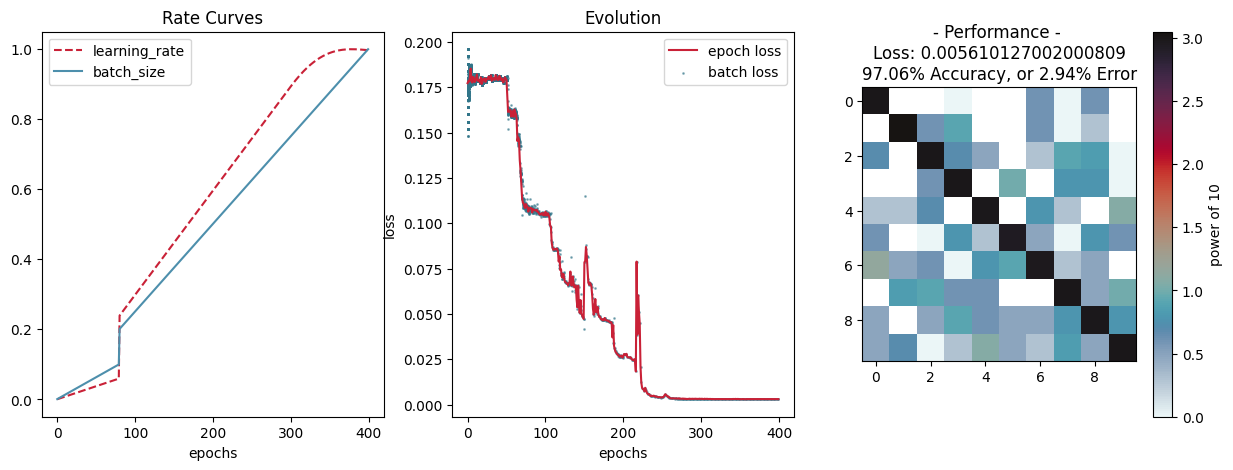

In [12]:
epochs = 400
max_batch_size=train_X.shape[0]
base_lr = 0.001
net = DNN() # expect 1.6% error rate
net.to(device)
report = train(net, epochs, max_batch_size, base_lr, train_X, train_y)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)

In [8]:
from torch.profiler import profile, record_function, ProfilerActivity

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [23:15<00:00,  3.49s/it]


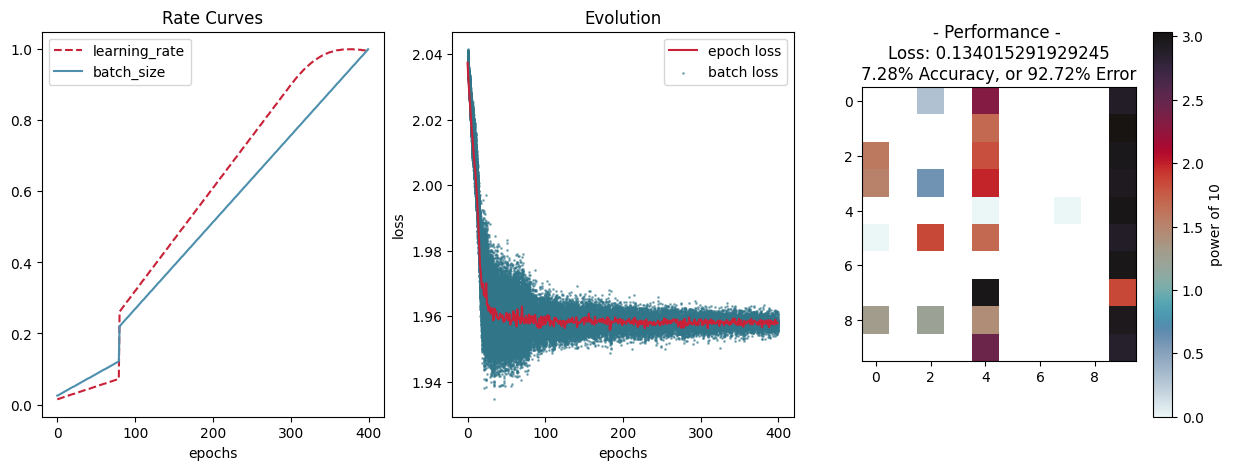

In [127]:
epochs = 400
max_batch_size=1600
base_lr = 0.0001

net = FFA(device) # expect 1.6% error rate
# with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
#     with record_function("model_inference"):
report = train(net, epochs, max_batch_size, base_lr, train_X, train_y,start_batch_size=40)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)

In [94]:
torch.cuda.memory_allocated()

637429248

In [120]:
print(net.forward(test_X[0:2]))
print(test_y[0:2])

tensor([[0.1282, 0.2063, 0.1617, 0.1792, 0.5304, 0.2784, 0.3188, 0.2979, 0.2235,
         0.4442],
        [0.3711, 0.2400, 0.3048, 0.3320, 0.3673, 0.3343, 0.2767, 0.2391, 0.3706,
         0.4736]], device='cuda:0')
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


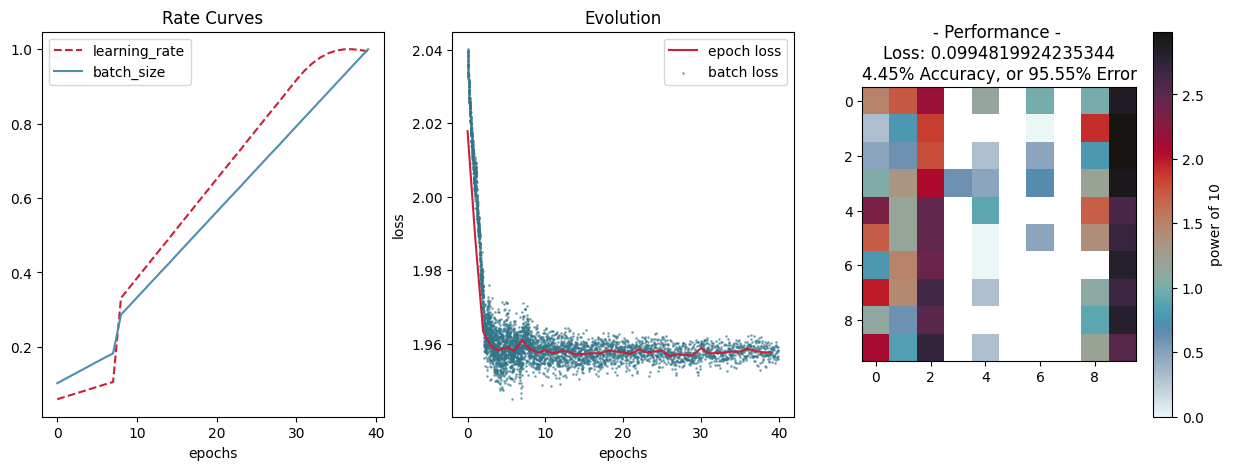

In [123]:
net2 = FFA(device)

ecran(net2, test_X, test_y, torch.nn.MSELoss(), report)

In [12]:
prof.export_chrome_trace("trace.json")

STAGE:2023-01-21 19:05:43 844:844 output_json.cpp:417] Completed Stage: Post Processing


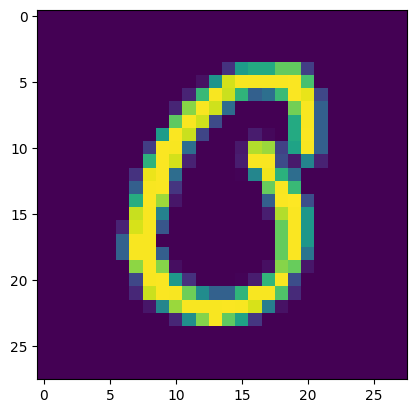

In [60]:
mask = (torch.rand((28,28)) > 0.5).to(device)
# plt.imshow(train_X[0].detach().cpu().numpy())
mixed = train_X[234]*mask + train_X[234]*(~mask)
plt.imshow(mixed.detach().cpu().numpy())